In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

In [2]:
spark = (SparkSession.builder.appName("SalesAnalytics").getOrCreate())

### Read 2019 data from Parquet files directory

In [3]:
source_data_path = "./data/output/sales/"
partition = "ReportYear=2019"
full_path = f"{source_data_path}{partition}"

In [4]:
sales2019_df = spark.read.parquet(full_path)
sales2019_df.show(10, truncate=False)

+-------+--------------------------+--------+------+-------------------+---------------------------------------+--------------+-----+-----+
|OrderID|Product                   |Quantity|Price |OrderDate          |StoreAddress                           |City          |State|Month|
+-------+--------------------------+--------+------+-------------------+---------------------------------------+--------------+-----+-----+
|295778 |AA Batteries (4-pack)     |1       |3.84  |2019-12-08 21:09:00|820 Adams St, San Francisco, CA 94016  | San Francisco|CA   |12   |
|296047 |AAA Batteries (4-pack)    |2       |2.99  |2019-12-02 18:09:00|433 4th St, Los Angeles, CA 90001      | Los Angeles  |CA   |12   |
|296233 |AA Batteries (4-pack)     |1       |3.84  |2019-12-05 15:49:00|444 8th St, Los Angeles, CA 90001      | Los Angeles  |CA   |12   |
|296603 |AAA Batteries (4-pack)    |1       |2.99  |2019-12-02 20:21:00|665 10th St, San Francisco, CA 94016   | San Francisco|CA   |12   |
|296639 |27in FHD Mo

### What was the best month in sales?

In [5]:
from pyspark.sql.functions import round, sum
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
sales_q1_df = (sales2019_df.select(
                           col("OrderId"), 
                           col("Month"),
                           col("Price"),
                           col("Quantity"),
                           expr("Price * Quantity").alias("Sales")))

In [7]:
sales_q1_df.show(10)

+-------+-----+------+--------+------+
|OrderId|Month| Price|Quantity| Sales|
+-------+-----+------+--------+------+
| 295778|   12|  3.84|       1|  3.84|
| 296047|   12|  2.99|       2|  5.98|
| 296233|   12|  3.84|       1|  3.84|
| 296603|   12|  2.99|       1|  2.99|
| 296639|   12|149.99|       1|149.99|
| 296749|   12|379.99|       1|379.99|
| 296810|   12| 11.99|       1| 11.99|
| 297143|   12| 150.0|       1| 150.0|
| 297288|   12|  3.84|       2|  7.68|
| 297311|   12| 99.99|       1| 99.99|
+-------+-----+------+--------+------+
only showing top 10 rows



In [8]:
sales_q1_df = (sales_q1_df
               .groupBy("Month")
               .agg(round(sum("Sales"), 2).alias("TotalSales"))
               .orderBy("TotalSales", ascending=False))

In [9]:
sales_q1_df.show(10)

+-----+----------+
|Month|TotalSales|
+-----+----------+
|   12|4608295.68|
|   10|3734777.84|
|    4|3389217.96|
|   11|3197875.03|
|    5|3150616.21|
|    3|2804973.34|
|    7|2646461.31|
|    6|2576280.14|
|    8|2241083.36|
|    2|2200078.07|
+-----+----------+
only showing top 10 rows



In [10]:
pd_sales_q1 = (sales_q1_df.orderBy("Month")).toPandas()

In [11]:
pd_sales_q1

,Month,TotalSales
0,1,1812742.86
1,2,2200078.07
2,3,2804973.34
3,4,3389217.96
4,5,3150616.21
5,6,2576280.14
6,7,2646461.31
7,8,2241083.36
8,9,2094465.68
9,10,3734777.84


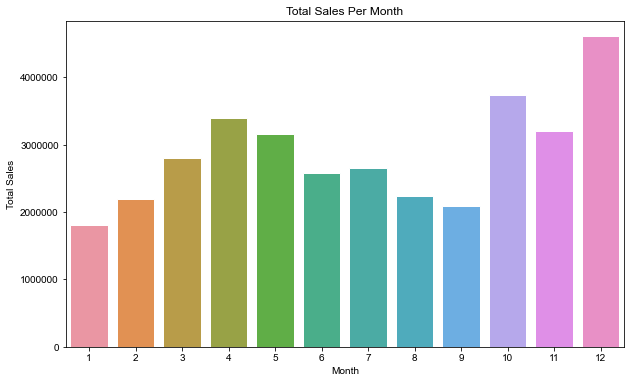

In [12]:
plt.figure(figsize=(10,6))
plt.ticklabel_format(useOffset=False, style='plain')
sns.set_theme(style="whitegrid")
sns.barplot(x="Month",y="TotalSales",data=pd_sales_q1).set_title("Total Sales Per Month")
plt.ylabel("Total Sales")
plt.show()

In [13]:
sales2019_df.show(10)

+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+
|OrderID|             Product|Quantity| Price|          OrderDate|        StoreAddress|          City|State|Month|
+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+
| 295778|AA Batteries (4-p...|       1|  3.84|2019-12-08 21:09:00|820 Adams St, San...| San Francisco|   CA|   12|
| 296047|AAA Batteries (4-...|       2|  2.99|2019-12-02 18:09:00|433 4th St, Los A...|   Los Angeles|   CA|   12|
| 296233|AA Batteries (4-p...|       1|  3.84|2019-12-05 15:49:00|444 8th St, Los A...|   Los Angeles|   CA|   12|
| 296603|AAA Batteries (4-...|       1|  2.99|2019-12-02 20:21:00|665 10th St, San ...| San Francisco|   CA|   12|
| 296639|    27in FHD Monitor|       1|149.99|2019-12-25 11:35:00|860 7th St, New Y...| New York City|   NY|   12|
| 296749|34in Ultrawide Mo...|       1|379.99|2019-12-05 21:21:00|570 Adams St, 

In [14]:
sales2019_df.select("OrderID","City").show()

+-------+--------------+
|OrderID|          City|
+-------+--------------+
| 295778| San Francisco|
| 296047|   Los Angeles|
| 296233|   Los Angeles|
| 296603| San Francisco|
| 296639| New York City|
| 296749|       Seattle|
| 296810|        Boston|
| 297143| San Francisco|
| 297288| San Francisco|
| 297311|   Los Angeles|
| 297531|        Boston|
| 297537|      Portland|
| 297999| San Francisco|
| 298321| New York City|
| 298578| New York City|
| 298774|        Boston|
| 298853|   Los Angeles|
| 298971| New York City|
| 299990|        Dallas|
| 300048| New York City|
+-------+--------------+
only showing top 20 rows



In [15]:
sales_q2_df = (sales2019_df.groupBy("City")
                           .agg(sum("Quantity").alias("TotalProducts"))
                           .orderBy("TotalProducts", ascending=False))

In [16]:
sales_q2_df.show(10, False)

+--------------+-------------+
|City          |TotalProducts|
+--------------+-------------+
| San Francisco|50156        |
| Los Angeles  |33246        |
| New York City|27887        |
| Boston       |22490        |
| Dallas       |16705        |
| Atlanta      |16584        |
| Seattle      |16533        |
| Portland     |14035        |
| Austin       |11135        |
+--------------+-------------+



In [17]:
pd_sales_q2 = sales_q2_df.toPandas()

In [18]:
pd_sales_q2

,City,TotalProducts
0,San Francisco,50156
1,Los Angeles,33246
2,New York City,27887
3,Boston,22490
4,Dallas,16705
5,Atlanta,16584
6,Seattle,16533
7,Portland,14035
8,Austin,11135


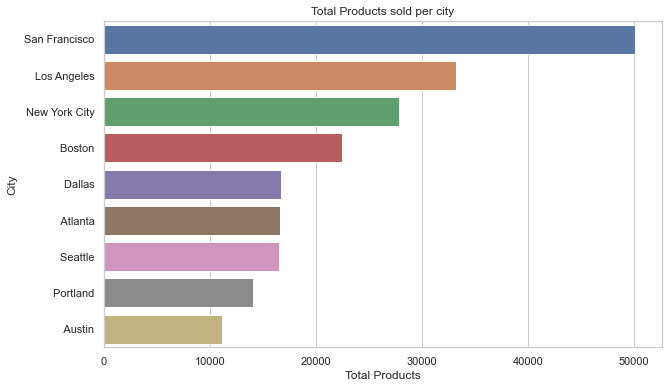

In [19]:
plt.figure(figsize=(10,6))
plt.ticklabel_format(useOffset=False, style='plain')
sns.set_theme(style="darkgrid")
sns.barplot(x="TotalProducts",y="City",data=pd_sales_q2).set_title("Total Products sold per city")
plt.xlabel("Total Products")
plt.show()

### What time should we display advertisement to maximise the likelihood of cutomers buying

In [20]:
from pyspark.sql.functions import count, date_format

In [21]:
sales2019_df.show(10)

+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+
|OrderID|             Product|Quantity| Price|          OrderDate|        StoreAddress|          City|State|Month|
+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+
| 295778|AA Batteries (4-p...|       1|  3.84|2019-12-08 21:09:00|820 Adams St, San...| San Francisco|   CA|   12|
| 296047|AAA Batteries (4-...|       2|  2.99|2019-12-02 18:09:00|433 4th St, Los A...|   Los Angeles|   CA|   12|
| 296233|AA Batteries (4-p...|       1|  3.84|2019-12-05 15:49:00|444 8th St, Los A...|   Los Angeles|   CA|   12|
| 296603|AAA Batteries (4-...|       1|  2.99|2019-12-02 20:21:00|665 10th St, San ...| San Francisco|   CA|   12|
| 296639|    27in FHD Monitor|       1|149.99|2019-12-25 11:35:00|860 7th St, New Y...| New York City|   NY|   12|
| 296749|34in Ultrawide Mo...|       1|379.99|2019-12-05 21:21:00|570 Adams St, 

In [22]:
sales2019_df.groupBy("OrderID").agg(count("OrderID").alias("count")).where(col("count") > 1).show(10, False)

+-------+-----+
|OrderID|count|
+-------+-----+
|304276 |2    |
|300601 |2    |
|310188 |2    |
|261569 |2    |
|188122 |2    |
|277349 |2    |
|269251 |2    |
|276515 |2    |
|265863 |2    |
|187647 |2    |
+-------+-----+
only showing top 10 rows



In [23]:
sales2019_df.filter(col("OrderID") == 304276).show(truncate=False)

+-------+---------------+--------+------+-------------------+-----------------------------------+--------------+-----+-----+
|OrderID|Product        |Quantity|Price |OrderDate          |StoreAddress                       |City          |State|Month|
+-------+---------------+--------+------+-------------------+-----------------------------------+--------------+-----+-----+
|304276 |ThinkPad Laptop|1       |999.99|2019-12-15 06:07:00|358 5th St, New York City, NY 10001| New York City|NY   |12   |
|304276 |iPhone         |1       |700.0 |2019-12-15 06:07:00|358 5th St, New York City, NY 10001| New York City|NY   |12   |
+-------+---------------+--------+------+-------------------+-----------------------------------+--------------+-----+-----+



### What time should we display avertisement to maximise the likelihood of customers buying products?

In [24]:
from pyspark.sql.functions import count, date_format

In [25]:
sales2019_df.show(10, False)

+-------+--------------------------+--------+------+-------------------+---------------------------------------+--------------+-----+-----+
|OrderID|Product                   |Quantity|Price |OrderDate          |StoreAddress                           |City          |State|Month|
+-------+--------------------------+--------+------+-------------------+---------------------------------------+--------------+-----+-----+
|295778 |AA Batteries (4-pack)     |1       |3.84  |2019-12-08 21:09:00|820 Adams St, San Francisco, CA 94016  | San Francisco|CA   |12   |
|296047 |AAA Batteries (4-pack)    |2       |2.99  |2019-12-02 18:09:00|433 4th St, Los Angeles, CA 90001      | Los Angeles  |CA   |12   |
|296233 |AA Batteries (4-pack)     |1       |3.84  |2019-12-05 15:49:00|444 8th St, Los Angeles, CA 90001      | Los Angeles  |CA   |12   |
|296603 |AAA Batteries (4-pack)    |1       |2.99  |2019-12-02 20:21:00|665 10th St, San Francisco, CA 94016   | San Francisco|CA   |12   |
|296639 |27in FHD Mo

In [26]:
sales2019_df.groupBy("OrderID").agg(count("OrderID").alias("count")).where(col("count") > 1).show(10,False)

+-------+-----+
|OrderID|count|
+-------+-----+
|304276 |2    |
|300601 |2    |
|310188 |2    |
|261569 |2    |
|188122 |2    |
|277349 |2    |
|269251 |2    |
|276515 |2    |
|265863 |2    |
|187647 |2    |
+-------+-----+
only showing top 10 rows



In [27]:
sales2019_df.filter(col("OrderID") == 304276).show(truncate=False)

+-------+---------------+--------+------+-------------------+-----------------------------------+--------------+-----+-----+
|OrderID|Product        |Quantity|Price |OrderDate          |StoreAddress                       |City          |State|Month|
+-------+---------------+--------+------+-------------------+-----------------------------------+--------------+-----+-----+
|304276 |ThinkPad Laptop|1       |999.99|2019-12-15 06:07:00|358 5th St, New York City, NY 10001| New York City|NY   |12   |
|304276 |iPhone         |1       |700.0 |2019-12-15 06:07:00|358 5th St, New York City, NY 10001| New York City|NY   |12   |
+-------+---------------+--------+------+-------------------+-----------------------------------+--------------+-----+-----+



In [28]:
sales_q3_df = (sales2019_df.select("OrderID", date_format("OrderDate","HH").cast("int").alias("Hour"))
                           .distinct()
                           .groupBy("Hour")
                           .agg(count("Hour").alias('TotalOrders'))
                           .orderBy(col("TotalOrders"), ascending=False))

In [29]:
sales_q3_df.show()

+----+-----------+
|Hour|TotalOrders|
+----+-----------+
|  19|      12377|
|  12|      12082|
|  11|      11882|
|  20|      11763|
|  18|      11761|
|  13|      11682|
|  14|      10522|
|  21|      10499|
|  10|      10492|
|  17|      10476|
|  16|       9960|
|  15|       9761|
|  22|       8453|
|   9|       8404|
|   8|       6036|
|  23|       5990|
|   7|       3836|
|   0|       3748|
|   6|       2375|
|   1|       2246|
+----+-----------+
only showing top 20 rows



In [30]:
pd_sales_q3 = sales_q3_df.orderBy("Hour").toPandas()

In [31]:
pd_sales_q3

,Hour,TotalOrders
0,0,3748
1,1,2246
2,2,1192
3,3,801
4,4,810
5,5,1258
6,6,2375
7,7,3836
8,8,6036
9,9,8404


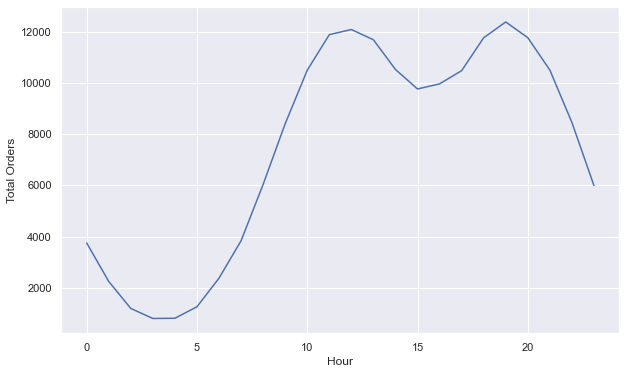

In [32]:
plt.figure(figsize=(10,6))
plt.ticklabel_format(useOffset=False, style='plain')
sns.set_theme(style="whitegrid")
sns.lineplot(x="Hour",y="TotalOrders",data=pd_sales_q3)
plt.ylabel("Total Orders")
plt.show()

### What Products are most often sold in the state of New York?

In [33]:
from pyspark.sql.functions import collect_list, size

In [34]:
sales2019_df.show()

+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+
|OrderID|             Product|Quantity| Price|          OrderDate|        StoreAddress|          City|State|Month|
+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+
| 295778|AA Batteries (4-p...|       1|  3.84|2019-12-08 21:09:00|820 Adams St, San...| San Francisco|   CA|   12|
| 296047|AAA Batteries (4-...|       2|  2.99|2019-12-02 18:09:00|433 4th St, Los A...|   Los Angeles|   CA|   12|
| 296233|AA Batteries (4-p...|       1|  3.84|2019-12-05 15:49:00|444 8th St, Los A...|   Los Angeles|   CA|   12|
| 296603|AAA Batteries (4-...|       1|  2.99|2019-12-02 20:21:00|665 10th St, San ...| San Francisco|   CA|   12|
| 296639|    27in FHD Monitor|       1|149.99|2019-12-25 11:35:00|860 7th St, New Y...| New York City|   NY|   12|
| 296749|34in Ultrawide Mo...|       1|379.99|2019-12-05 21:21:00|570 Adams St, 

In [35]:
sales_q4_df = (sales2019_df.where(col("state") == 'NY')
                           .orderBy("OrderID","Product")
                           .groupBy("OrderID","state")
                           .agg(collect_list('Product').alias("ProductList")))

In [36]:
sales_q4_df.show(10, False)

+-------+-----+------------------------------------------------+
|OrderID|state|ProductList                                     |
+-------+-----+------------------------------------------------+
|141851 |NY   |[27in FHD Monitor]                              |
|142149 |NY   |[AA Batteries (4-pack)]                         |
|142787 |NY   |[Lightning Charging Cable]                      |
|143020 |NY   |[ThinkPad Laptop]                               |
|143862 |NY   |[Apple Airpods Headphones]                      |
|144151 |NY   |[LG Dryer]                                      |
|144851 |NY   |[Apple Airpods Headphones, USB-C Charging Cable]|
|146589 |NY   |[Wired Headphones]                              |
|147784 |NY   |[AAA Batteries (4-pack)]                        |
|148099 |NY   |[27in 4K Gaming Monitor]                        |
+-------+-----+------------------------------------------------+
only showing top 10 rows



In [37]:
sales_q4_df = (sales_q4_df.withColumn("ProductListSize", size("productList")))
sales_q4_df.filter(col("ProductListSize") > 1).orderBy("ProductList").show(10, False)

+-------+-----+----------------------------------------+---------------+
|OrderID|state|ProductList                             |ProductListSize|
+-------+-----+----------------------------------------+---------------+
|253929 |NY   |[20in Monitor, 27in 4K Gaming Monitor]  |2              |
|197004 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|248053 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|266247 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|158102 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|176251 |NY   |[20in Monitor, AAA Batteries (4-pack)]  |2              |
|245465 |NY   |[20in Monitor, AAA Batteries (4-pack)]  |2              |
|194762 |NY   |[20in Monitor, AAA Batteries (4-pack)]  |2              |
|234956 |NY   |[20in Monitor, Apple Airpods Headphones]|2              |
|204645 |NY   |[20in Monitor, Apple Airpods Headphones]|2              |
+-------+-----+------------------------------------

In [38]:
(sales_q4_df.filter(col("ProductListSize") > 1)
            .groupBy("ProductList")
            .count()
            .orderBy("count", ascending=False).show(10, False))

+--------------------------------------------------+-----+
|ProductList                                       |count|
+--------------------------------------------------+-----+
|[Google Phone, USB-C Charging Cable]              |127  |
|[Lightning Charging Cable, iPhone]                |126  |
|[Google Phone, Wired Headphones]                  |53   |
|[USB-C Charging Cable, Vareebadd Phone]           |50   |
|[Wired Headphones, iPhone]                        |46   |
|[Apple Airpods Headphones, iPhone]                |45   |
|[Bose SoundSport Headphones, Google Phone]        |24   |
|[Apple Airpods Headphones, Wired Headphones]      |19   |
|[Vareebadd Phone, Wired Headphones]               |17   |
|[AAA Batteries (4-pack), Lightning Charging Cable]|16   |
+--------------------------------------------------+-----+
only showing top 10 rows

